In [3]:
import pickle
import pandas as pd
import numpy as np
from IPython.display import Audio
import torch
import torchaudio
from IPython.display import Audio, display
import json
import os
from pathlib import Path

In [8]:
import pickle
import pandas as pd
import numpy as np
from IPython.display import Audio
import torch
import torchaudio
from IPython.display import Audio, display
import json
import os
from pathlib import Path
# import shutil
from glob import glob



def get_df(exp_root, dir):
    exp_dir = Path(exp_root)/dir
    pkl_results_file = os.path.join(exp_dir, "measures.pickle")

    with open(pkl_results_file, "rb") as handle:
        dfme = pd.read_pickle(handle).reset_index(drop=True)
    return dfme


def get_df_storm(pkl_results_file, snr=None):
    # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_l/enhanced/storm_vbd/measures_storm.pickle"
    # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_k/enhanced/storm_TIMITChime3/measures_storm.pickle"
        # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_l/enhanced/sgmse_WSJ0Chime3/measures_storm.pickle"
    # pkl_results_file = "/data/ephraim/datasets/known_noise/sgmse/exp_k/enhanced/sgmse_TIMITChime3/measures_storm.pickle"
    with open(pkl_results_file, "rb") as handle:
        df2 = pd.read_pickle(handle)
    for i in range(len(df2["snr"])):
        df2.at[i, "snr"] = df2["snr"][i].split("_")[0]
    if snr is None:
        df_storm_ = df2.reset_index(drop=True).sort_values(by=['dir'])
    else:
        df_storm_ = df2[df2["snr"]==snr].reset_index(drop=True).sort_values(by=['dir'])
    return df_storm_


def write_results(df, name_alg,analysis_root,noises):
    print("write")
    # df.to_excel(os.path.join(analysis_root, f"{name_alg}_all.xlsx"))
    # for noisetype in noises:
    #     noise_mine  = df[df["noise_type"]==noisetype]
    #     noise_mine.to_excel(os.path.join(analysis_root, f"{name_alg}_{noisetype}.xlsx"))


def drop_rows_without_comparison(df, ours_df):
    for i in range(len(df["dir"])):
        dir_ = df["dir"][i]
        noisetype = df["noise_type"][i]
        mine_parallel = ours_df[(ours_df["dir"]==dir_) & (ours_df["noise_type"]==noisetype)]
        if len(mine_parallel)==0:
            idx = df[(df.dir==dir_)&(df.noise_type==noisetype)].index
            df = df.drop(idx)
        return df


def get_stats_df(df, alg_name, dir_=None, noise_type=None, snr_=None):
    if dir_:
        df = df[df["dir"]==dir_]
    if noise_type:
        df = df[df["noise_type"]==noise_type]
    if snr_:
        df = df[df["snr"]==snr_]
    dfstats = df.describe()[1:3]
    dfstats = dfstats.assign(alg=alg_name)
    return dfstats


def create_mine_df(exp_root,df_noisy,mine,noises,cols,names,snrs):
    for d in names: 
        dfme = get_df(exp_root,d)
        if dfme is None:
            continue
        dfme = dfme.assign(dir=d)
        cur_df_noisy = dfme[dfme["name"]=="noisy"].reset_index(drop=True)
        cur_df_noisy.loc[0,"dir"] = d
        if df_noisy is None:
            df_noisy = cur_df_noisy
        else:
            df_noisy = pd.concat([df_noisy, cur_df_noisy])
        dfme = dfme[dfme["name"] != "noisy"]
        
        dfme = dfme[dfme["stoi"]>0.5]

        for noisetype in noises :
            for c_snr in snrs:
                c_snr=str(c_snr)
                dfme_cur = dfme[dfme["snr"]==c_snr]
                cur_mine = dfme_cur[dfme_cur["noise_type"]==noisetype]
                cur_mine = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]
                if mine is None:
                    mine = cur_mine
                else:
                    mine = pd.concat([mine, cur_mine])
    mine=mine.reset_index(drop=True)
    return mine, df_noisy

# def copy_wavs(df,wavdst,algname):
#     df = df.reset_index(drop=True)
#     for i in df.index.values:
#         wavpath = df["filename"][i]
#         dir_ = df["dir"][i]
#         snr = df["snr"][i]
#         noisetype = df["noise_type"][i]
#         name = f"{dir_}_{noisetype}_snr{snr}_{algname}.wav"
#         dst = wavdst/f"{name}"
#         print("origin:", wavpath)
#         print("dst:", dst)
#         shutil.copyfile(wavpath, dst)


from audio_tools2  import *
def calc_vad(f, verbose=False):
    test_file=f
    fs,s = read_wav(test_file)
    win_len = int(fs*0.025)
    hop_len = int(fs*0.010)
    sframes = enframe(s,win_len,hop_len) # rows: frame index, cols: each frame
    if verbose:
        plot_this(compute_log_nrg(sframes))

    # percent_high_nrg is the VAD context ratio. It helps smooth the
    # output VAD decisions. Higher values are more strict.
    percent_high_nrg = 0.5

    vad = nrg_vad(sframes,percent_high_nrg)

    if verbose:
        plot_these(deframe(vad,win_len,hop_len),s)
    return deframe(vad,win_len,hop_len) 


   



In [9]:


    
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear": ###chosen in default
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        # scale = 1000 / num_diffusion_timesteps
        beta_start = 0.0001  # scale * 0.0001
        beta_end = 0.02  # scale * 0.02
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].
    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)



betas=get_named_beta_schedule("linear", 200)
alphas = 1.0 - betas
alphas_cumprod =  torch.from_numpy(np.cumprod(alphas, axis=0))
g_t = torch.sqrt((1-alphas_cumprod)/(alphas_cumprod))



In [10]:
snrs=[]
for d in os.listdir("/data/ephraim/datasets/known_noise/undiff_exps/exp_n_real/"):
    if not d in ['5f_snrs.pickle', 'storm', 'analysis','noises','noisy_wav','clean_wav']:
        enh_dir = Path(exp_root)/d/"enhanced_60"
        snr_dir=os.listdir(enh_dir)
        for s in snr_dir:
            c_snr = s.split("snr")[1]
            if c_snr not in snrs:
                snrs.append(c_snr)

NameError: name 'exp_root' is not defined

In [11]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_m_net4/","p")[cols]
df3[df3["pesq"] == df3["pesq"].max()]#  = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
15,s0.15,0.849983,0.836185,1.741564,1.050526,2.655808,2.961207,3.935246,11.117456,11.844162,11.844162,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [6]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_m_net6/","p")[cols]
df3[df3["pesq"] == df3["pesq"].max()]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
16,s0.15,0.842428,0.833336,1.677414,1.049168,2.811136,3.152923,3.938843,10.915897,11.212806,11.212806,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [7]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_m_net6mog5/","p")[cols]
df3[df3["pesq"] == df3["pesq"].max()]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
2,s0.09,0.375201,0.824194,1.237327,1.050897,1.08704,1.180088,1.110806,-33.779175,-20.923484,-20.923484,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [ ]:
df_sg[["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]]

In [9]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_m20_net6/","p")[cols]
df3[df3["pesq"] == df3["pesq"].max()]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
5,s0.15,0.842427,0.839015,1.680002,1.049419,2.825928,3.196409,3.938408,11.480137,11.065715,11.065715,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [1]:
cols =["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
df3 = get_df("/data/ephraim/datasets/known_noise/undiff_exps/exp_m20_net6d/","p")[cols]
df3[df3["pesq"] == df3["pesq"].max()]

NameError: name 'get_df' is not defined

In [13]:
df_sg2[["name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]]

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
3,ise1_digits_snr5_power0.0005413281032815576_va...,0.900452,0.830965,1.193118,1.048187,2.549578,3.401593,2.879831,9.994113,10.254024,10.254024,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5
0,noise1_digits_snr5_power0.0005413281032815576_...,0.907489,0.833336,1.315031,1.049168,2.497692,3.279732,2.888491,8.899231,9.133562,9.133562,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5
1,noise1_digits_snr5_power0.0005413281032815576_...,0.892480,0.836185,1.209340,1.050526,2.679739,3.413856,3.130307,9.458393,9.686685,9.686685,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5
2,noise1_digits_snr5_power0.0005413281032815576_...,0.906941,0.839750,1.267233,1.049574,2.826187,3.453710,3.301211,10.332593,10.690415,10.690415,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5
4,noise1_digits_snr5_power0.0005413281032815576_...,0.899144,0.830965,1.272204,1.048187,2.767370,3.410807,3.286999,9.630277,9.901086,9.901086,inf,1,/data/ephraim/datasets/known_noise/undiff_exps...,5


In [ ]:
df_sg2

In [12]:
df_sg["filename"][2]

'/data/ephraim/datasets/known_noise/undiff_exps/exp_m_net4/storm/enhanced/sgmse_WSJ0Chime3/p_noise1_digits_snr5_power0.0005413281032815576_var0.000444787903688848.wav'

In [35]:
df4

,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr,s
0,s0.07,0.715264,0.811797,1.203798,1.047665,2.211635,2.581555,3.572479,5.431159,6.704767,6.704767,inf,34,/data/ephraim/datasets/known_noise/undiff_exps...,5,0.07
1,s0.09,0.760825,0.811797,1.296537,1.047665,2.514472,3.038712,3.449995,6.689730,7.604238,7.604238,inf,34,/data/ephraim/datasets/known_noise/undiff_exps...,5,0.09
2,s0.1,0.770637,0.811797,1.287699,1.047665,2.196974,2.727239,3.280483,7.247449,8.001984,8.001984,inf,34,/data/ephraim/datasets/known_noise/undiff_exps...,5,0.10
3,s0.11,0.784417,0.811797,1.376264,1.047665,2.424569,3.006763,3.283287,7.799353,8.383014,8.383014,inf,34,/data/ephraim/datasets/known_noise/undiff_exps...,5,0.11
4,s0.14,0.800805,0.811797,1.348902,1.047665,2.345482,2.847700,3.291454,7.749473,8.164807,8.164807,inf,34,/data/ephraim/datasets/known_noise/undiff_exps...,5,0.14
5,s0.15,0.805029,0.811797,1.316012,1.047665,2.270553,2.975242,3.020909,7.586082,7.960793,7.960793,inf,34,/data/ephraim/datasets/known_noise/undiff_exps...,5,0.15
6,s0.16,0.804935,0.811797,1.322574,1.047665,2.430779,3.037664,3.196234,7.688558,8.019402,8.019402,inf,34,/data/ephraim/datasets/known_noise/undiff_exps...,5,0.16
7,s0.17,0.830827,0.811797,1.348944,1.047665,2.424115,3.051456,3.141908,7.800181,8.082373,8.082373,inf,34,/data/ephraim/datasets/known_noise/undiff_exps...,5,0.17
8,s0.2,0.826577,0.811797,1.320332,1.047665,2.213368,2.907436,2.981747,7.659661,7.891566,7.891566,inf,34,/data/ephraim/datasets/known_noise/undiff_exps...,5,0.20
9,s0.23,0.819283,0.811797,1.306557,1.047665,2.180128,3.087877,2.702666,7.614632,7.776507,7.776507,inf,34,/data/ephraim/datasets/known_noise/undiff_exps...,5,0.23


In [12]:

storm_enhanced_path = "/data/ephraim/datasets/known_noise/undiff_exps/exp_m20_net6d/storm/enhanced/"
storm_results_path = os.path.join(storm_enhanced_path,"sgmse_TIMITChime3/measures_storm.pickle")
sgmse_results_path = os.path.join(storm_enhanced_path,"sgmse_WSJ0Chime3/measures_storm.pickle")
df_storm2 = get_df_storm(storm_results_path)
df_sg2 = get_df_storm(sgmse_results_path)

In [7]:

storm_enhanced_path = "/data/ephraim/datasets/known_noise/undiff_exps/exp_m_net4/storm/enhanced/"
storm_results_path = os.path.join(storm_enhanced_path,"sgmse_TIMITChime3/measures_storm.pickle")
sgmse_results_path = os.path.join(storm_enhanced_path,"sgmse_WSJ0Chime3/measures_storm.pickle")
df_storm = get_df_storm(storm_results_path)
df_sg = get_df_storm(sgmse_results_path)

In [27]:
mine = None
for d in names: 
    dfme = get_df(exp_root,d)
    if dfme is None:
        continue
    dfme = dfme.assign(dir=d)
    cur_df_noisy = dfme[dfme["name"]=="noisy"].reset_index(drop=True)
    cur_df_noisy.loc[0,"dir"] = d
    if df_noisy is None:
        df_noisy = cur_df_noisy
    else:
        df_noisy = pd.concat([df_noisy, cur_df_noisy])
    dfme = dfme[dfme["name"] != "noisy"]
    
    dfme = dfme[dfme["stoi"]>0.5]

    for noisetype in NOISES :
        for c_snr in snrs:
            c_snr=str(c_snr)
            dfme_cur = dfme[dfme["snr"]==c_snr]
            cur_mine = dfme_cur[dfme_cur["noise_type"]==noisetype]
            cur_mine = cur_mine[cur_mine["pesq"] ==cur_mine["pesq"].max()].reset_index(drop=True)[cols]
            if mine is None:
                mine = cur_mine
            else:
                mine = pd.concat([mine, cur_mine])
mine=mine.reset_index(drop=True)

In [28]:
mine

,dir,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
1,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
2,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
3,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
4,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
5,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
6,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
7,30X8,s0.07,0.522199,0.556660,1.098023,1.027847,1.955531,2.983263,2.485383,-1.011123,3.165108,3.165108,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
8,30X8,s0.07,0.522199,0.556660,1.098023,1.027847,1.955531,2.983263,2.485383,-1.011123,3.165108,3.165108,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
9,30X8,s0.07,0.522199,0.556660,1.098023,1.027847,1.955531,2.983263,2.485383,-1.011123,3.165108,3.165108,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5


In [17]:

snrs

['-5', '0', '5', '10', '15', '25']

In [25]:
exp_root = "/data/ephraim/datasets/known_noise/undiff_exps/exp_n_find_params/"
storm_enhanced_path = str( Path(exp_root)/"storm/enhanced/")
storm_clean_wav = str(Path(exp_root)/"storm"/"clean_wav")

cols =["dir","name","stoi","input_stoi","pesq","input_pesq","OVRL","SIG","BAK","si_sdr",'sdr', "sar",'sir',"noise_type", "filename","snr"]
mine = None
df_noisy = None


names = []
for d in os.listdir(exp_root):
    if not d in ['5f_snrs.pickle', 'storm', 'analysis','noises','noisy_wav','clean_wav',"cleans"]:
        names.append(d)

NOISES =[]
noises_root = Path(exp_root)/"noises"
for n in os.listdir(noises_root):
    n = n.split("fileid_")[1].split(".wav")[0]
    
    if "X" in n:
        n = n.split("X")[0]
    NOISES.append(n)
snrs = []
for d in os.listdir(exp_root):
    if not d in ['5f_snrs.pickle', 'storm', 'analysis','noises','noisy_wav','clean_wav',"cleans"]:
        enh_dir = Path(exp_root)/d/"enhanced_60"
        snr_dir=os.listdir(enh_dir)
        for s in snr_dir:
            c_snr = s.split("snr")[1]
            if c_snr not in snrs:
                snrs.append(c_snr)

In [ ]:



mine, df_noisy = create_mine_df(exp_root,df_noisy,mine,noises=NOISES,cols=cols,names=names,snrs=snrs)

analysis_root = os.path.join(exp_root, "analysis")
if not os.path.exists(analysis_root):
    os.mkdir(analysis_root)

SGMSE = "sgmseWSJ0"
STORM = "sgmseTIMIT"
storm_results_path = os.path.join(storm_enhanced_path,"sgmse_TIMITChime3/measures_storm.pickle")
sgmse_results_path = os.path.join(storm_enhanced_path,"sgmse_WSJ0Chime3/measures_storm.pickle")
df_storm = get_df_storm(storm_results_path)
df_sg = get_df_storm(sgmse_results_path)
write_results(mine,"ours",analysis_root=analysis_root, noises=NOISES)
write_results(df_sg,SGMSE,analysis_root=analysis_root, noises=NOISES)
write_results(df_storm,STORM,analysis_root=analysis_root, noises=NOISES)

df_storm = drop_rows_without_comparison(df_storm, mine)
df_sg= drop_rows_without_comparison(df_sg, mine)


minestats = get_stats_df(mine, "ours")
df_storm_stats = get_stats_df(df_storm, STORM)
df_sg_stats = get_stats_df(df_sg, SGMSE)
statsdf = pd.concat([minestats,df_sg_stats,df_storm_stats])
statsdf_path = os.path.join(analysis_root,"all_stats.xlsx")
# statsdf.to_excel(statsdf_path)


for dir__ in names:
    dirminestats = get_stats_df(mine, "ours", dir__)
    dir_storm_stats =  get_stats_df(df_storm[cols], STORM, dir__)
    dir_sg_stats =  get_stats_df(df_sg[cols], SGMSE, dir__)
    dirstatsdf = pd.concat([dirminestats,dir_storm_stats,dir_sg_stats])
    dir_statsdf_path = os.path.join(analysis_root,f"{dir__}_stats.xlsx")
    # dirstatsdf.to_excel(dir_statsdf_path) 


for noisetype in NOISES:
    minestats = get_stats_df(mine, "ours", noise_type=noisetype)
    df_storm_stats = get_stats_df(df_storm[cols], STORM, noise_type=noisetype)
    df_sg_stats = get_stats_df(df_sg[cols], SGMSE, noise_type=noisetype)
    statsdf = pd.concat([minestats,df_sg_stats,df_storm_stats])
    noise_statsdf_path = os.path.join(analysis_root,f"stats_{noisetype}.xlsx")
    # statsdf.to_excel(noise_statsdf_path)
    
for c_snr in snrs:
    c_snr = str(c_snr)
    minestats = get_stats_df(mine, "ours", snr_=c_snr)
    df_storm_stats = get_stats_df(df_storm[cols], STORM, snr_=c_snr)
    df_sg_stats = get_stats_df(df_sg[cols], SGMSE, snr_=c_snr)
    statsdf = pd.concat([minestats,df_sg_stats,df_storm_stats])
    snr_statsdf_path = os.path.join(analysis_root,f"stats_snr{c_snr}.xlsx")
    # statsdf.to_excel(snr_statsdf_path)

wavs_analysis_path = Path(exp_root)/"analysis"/"wavs"
if not os.path.exists(wavs_analysis_path):
    os.mkdir(wavs_analysis_path)


# copy_wavs(mine, wavs_analysis_path, "ours")
# copy_wavs(df_sg, wavs_analysis_path, SGMSE)
# copy_wavs(df_storm, wavs_analysis_path, STORM)
# copy_wavs(df_noisy, wavs_analysis_path, "noisy")

wavs = glob(str(Path(storm_clean_wav)) + "/*.wav")
for wavpath in wavs:
    c = Path(wavpath).name.split("_")[0]
    if "snr" in wavpath:
        snr = wavpath.split("snr")[1].split("_")[0]
        noisetype = Path(wavpath).name.split("noise")[1].split("_")[0]
        name = f"{c}_{noisetype}_snr{snr}_clean.wav"
        dst = wavs_analysis_path/f"{name}"
        # shutil.copyfile(wavpath, dst)

df = mine    
for i in df.index.values:
    snr = df["snr"][i]
    noisetype = df["noise_type"][i]
    dir_ = df["dir"][i]
    s = float(df["name"][i].replace("s",""))
    wavpath = df["filename"][i]
    noisy_path = Path(exp_root) / dir_ / "noisy_wav" / Path(wavpath).name

    speech, sr = torchaudio.load(noisy_path)
    vaded_signal = calc_vad(noisy_path)[0:speech.shape[1],:]
    vaded_signal_torch = (speech[0][vaded_signal.T[0]>0])
    vaded_signal_torch = torch.unsqueeze(vaded_signal_torch, dim=0)
    clean_power = float( 1 / vaded_signal_torch.shape[1] * torch.sum(vaded_signal_torch**2))
    simple_power =  float(1 / speech.shape[1] * torch.sum(speech**2))
    vaded_rate = (vaded_signal_torch.shape[1]/speech.shape[1])
    
    variance = float( torch.var(speech, unbiased=True))
    df.at[i, "clean_power"] = clean_power
    df.at[i, "simple_power"] = simple_power
    df.at[i, "vaded_rate"] = vaded_rate
    df.at[i, "variance"] = variance
write_results(mine,"ours_params",analysis_root=analysis_root, noises=NOISES)

write
write
write


/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: inva

write


In [16]:
mine[cols]

,dir,name,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,noise_type,filename,snr
0,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
1,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
2,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
3,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
4,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
5,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
6,30X0.5,s0.15,0.509389,0.520710,1.046765,1.025072,2.232686,3.265225,2.399289,-2.222967,-1.431783,-1.431783,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
7,30X8,s0.07,0.522199,0.556660,1.098023,1.027847,1.955531,2.983263,2.485383,-1.011123,3.165108,3.165108,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
8,30X8,s0.07,0.522199,0.556660,1.098023,1.027847,1.955531,2.983263,2.485383,-1.011123,3.165108,3.165108,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5
9,30X8,s0.07,0.522199,0.556660,1.098023,1.027847,1.955531,2.983263,2.485383,-1.011123,3.165108,3.165108,inf,30,/data/ephraim/datasets/known_noise/undiff_exps...,-5


In [22]:
mine.filename[0]

'/data/ephraim/datasets/known_noise/undiff_exps/exp_n_find_params/30X0.5/enhanced_60/snr-5/s0.15/noise30_book_07848_chp_0026_reader_03390_62_LoiPr_bDqow_snr-5_fileid_30.wav'

In [23]:
mine.filename[1]

'/data/ephraim/datasets/known_noise/undiff_exps/exp_n_find_params/30X0.5/enhanced_60/snr-5/s0.15/noise30_book_07848_chp_0026_reader_03390_62_LoiPr_bDqow_snr-5_fileid_30.wav'

In [68]:
s_array = []
snr_array = []
for j,n in enumerate(mine["name"]):
    n = float(n.split("s")[1])
    s_array.append(n)
    snr_ = float(mine["snr"][j])
    snr_array.append(snr_)

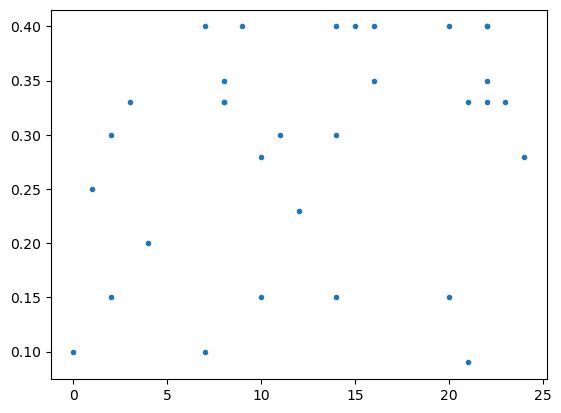

In [70]:
from matplotlib import pyplot as pyplot
plt.plot(snr_array,s_array, ".")

In [62]:
df_storm

,input_si_sdr,input_sdr,input_sir,input_sar,input_stoi,input_pesq,si_sdr,sdr,sir,sar,...,len_in_sec,sr,num_hops,OVRL_raw,SIG_raw,BAK_raw,OVRL,SIG,BAK,P808_MOS
0,19.044601,19.261939,inf,19.261939,0.984783,1.511858,19.149817,20.223051,inf,20.223051,...,1.0,16000,7,3.489866,3.866767,3.790649,3.114771,3.470394,3.811744,3.259311
11,15.845555,15.989218,inf,15.989218,0.967944,1.630079,10.564348,14.335066,inf,14.335066,...,1.0,16000,7,3.164615,3.406256,4.081295,2.898413,3.189435,3.978186,2.666927
1,11.635814,11.691771,inf,11.691771,0.000010,2.405081,9.419553,11.625541,inf,11.625541,...,1.0,16000,7,1.732680,2.067672,3.877525,1.775633,2.170534,3.863826,2.143417
2,7.037966,7.182994,inf,7.182994,0.850558,1.243633,11.537142,12.472015,inf,12.472015,...,1.0,16000,7,2.910105,3.475485,3.329777,2.719128,3.233946,3.502215,3.340996
3,-3.183176,-2.746943,inf,-2.746943,0.918516,1.049655,8.489678,10.967233,inf,10.967233,...,1.0,16000,7,3.272453,3.674097,3.939190,2.971733,3.357179,3.899588,3.212984
4,18.083784,18.231626,inf,18.231626,0.996507,1.920491,20.019300,22.028698,inf,22.028698,...,1.0,16000,7,3.814709,4.070766,4.349226,3.316569,3.583472,4.111916,3.203244
5,2.103903,2.286643,inf,2.286643,0.835145,1.094843,7.568219,10.530264,inf,10.530264,...,1.0,16000,7,2.347610,2.693429,3.510731,2.291793,2.684303,3.630416,2.557229
6,15.701641,15.767507,inf,15.767507,0.946110,1.397057,1.520924,6.051431,inf,6.051431,...,1.0,16000,7,2.664767,2.918439,3.952337,2.538006,2.852969,3.907083,3.415136
7,49.453979,49.558045,inf,49.558045,0.999989,4.604765,20.729753,22.245195,inf,22.245195,...,1.0,16000,7,3.188835,3.848099,3.405895,2.915017,3.459698,3.557193,3.300251
8,10.365370,10.429481,inf,10.429481,0.982477,1.459366,16.651371,17.326964,inf,17.326964,...,1.0,16000,7,2.712461,3.493174,2.948493,2.573854,3.245191,3.203859,2.993330


In [59]:
statsdf

,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,sir,alg
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ours
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ours
mean,0.995513,1.0,3.970256,4.643888,2.577860,3.355454,3.131377,27.118950,28.821500,28.821500,inf,sgmseWSJ0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sgmseWSJ0
mean,0.998486,1.0,4.100904,4.643888,2.575442,3.346675,3.138208,26.510944,27.288822,27.288822,inf,sgmseTIMIT
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sgmseTIMIT


In [60]:
minestats = get_stats_df(mine, "ours")
df_storm_stats = get_stats_df(df_storm, STORM)
df_sg_stats = get_stats_df(df_sg, SGMSE)
statsdf = pd.concat([minestats,df_sg_stats,df_storm_stats])

/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/data/ephraim/downloads/anaconda/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [61]:
statsdf

,stoi,input_stoi,pesq,input_pesq,OVRL,SIG,BAK,si_sdr,sdr,sar,...,input_sdr,input_sir,input_sar,len_in_sec,sr,num_hops,OVRL_raw,SIG_raw,BAK_raw,P808_MOS
mean,0.902843,0.932955,1.787736,2.166166,2.417048,2.955266,3.189094,12.433356,13.301288,13.301288,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,0.087789,0.087645,0.538746,1.160395,0.494887,0.577697,0.654102,7.038084,7.046334,7.046334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,0.926095,0.891024,2.540925,2.213294,2.655861,3.202192,3.481146,16.711723,17.663817,17.663817,...,24.680217,inf,24.680217,1.0,16000.0,7.0,2.843768,3.446596,3.375251,3.044913
std,0.181764,0.203897,0.988605,1.200482,0.355640,0.276429,0.531631,7.749667,7.650861,7.650861,...,47.901067,NaN,47.901067,0.0,0.0,0.0,0.479244,0.403448,0.650338,0.337169
mean,0.921770,0.891024,2.285547,2.213294,2.622242,3.156059,3.501604,15.440343,16.913946,16.913946,...,24.680217,inf,24.680217,1.0,16000.0,7.0,2.798898,3.380492,3.394395,3.045210
std,0.177343,0.203897,0.948069,1.200482,0.365645,0.317326,0.476935,6.741400,6.159339,6.159339,...,47.901067,NaN,47.901067,0.0,0.0,0.0,0.490236,0.451182,0.608629,0.363423
